6. Pipeline Stages: Create stages for the ML pipeline:
String Indexing: Convert categorical string columns into indexed numerical columns.
One Hot Encoding: Convert indexed columns into one-hot encoded vectors.
Vector Assembler for Numeric Features: Assemble numeric columns into a single vector.
Standard Scaler: Scale numeric features to have zero mean and unit variance.
Feature Assembler: Combine all encoded categorical features and scaled numeric features into a single feature vector.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 15.5 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=eb816c2a0ceb918f9bb9bf897411732025a034de4d83ff66db692d56694a7902
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
from pyspark.sql.functions import when, col, mean
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize Spark Session
spark = SparkSession.builder.appName("MentalHealthPrediction").getOrCreate()

Add this after reading the data and before preprocessing

In [3]:
# Define schema
schema = StructType([
    StructField("Name", StringType(), True),
    StructField("Age", IntegerType(), True),
    StructField("Marital_Status", StringType(), True),
    StructField("Education_Level", StringType(), True),
    StructField("Number_of_Children", IntegerType(), True),
    StructField("Smoking_Status", StringType(), True),
    StructField("Physical_Activity_Level", StringType(), True),
    StructField("Employment_Status", StringType(), True),
    StructField("Income", DoubleType(), True),
    StructField("Alcohol_Consumption", StringType(), True),
    StructField("Dietary_Habits", StringType(), True),
    StructField("Sleep_Patterns", StringType(), True),
    StructField("History_of_Mental_Illness", StringType(), True),
    StructField("History_of_Substance_Abuse", StringType(), True),
    StructField("Family_History_of_Depression", StringType(), True),
    StructField("Chronic_Medical_Conditions", StringType(), True)
])

# Read data
df = spark.read.csv("/content/drive/MyDrive/Bigdata_Dataset/depression_data.csv",
                    header=True, schema=schema)

In [4]:
# Check missing values
print("Missing Values Count:")
for column in df.columns:
    missing_count = df.filter(col(column).isNull()).count()
    if missing_count > 0:
        print(f"{column}: {missing_count}")

# Define columns
categorical_cols = [
    "Marital_Status", "Education_Level", "Smoking_Status",
    "Physical_Activity_Level", "Employment_Status",
    "Alcohol_Consumption", "Dietary_Habits", "Sleep_Patterns",
    "History_of_Mental_Illness", "History_of_Substance_Abuse",
    "Family_History_of_Depression", "Chronic_Medical_Conditions"
]

numeric_cols = ["Age", "Income", "Number_of_Children"]

# Handle missing values for numeric columns
numeric_means = df.select([mean(col).alias(col) for col in numeric_cols]).collect()[0]
for col_name in numeric_cols:
    df = df.withColumn(
        col_name,
        when(df[col_name].isNull(), numeric_means[col_name])
        .otherwise(df[col_name])
    )

# Handle missing values for categorical columns
for col_name in categorical_cols:
    mode_value = df.groupBy(col_name).count().orderBy('count', ascending=False).first()[0]
    df = df.withColumn(
        col_name,
        when(df[col_name].isNull(), mode_value)
        .otherwise(df[col_name])
    )

Missing Values Count:


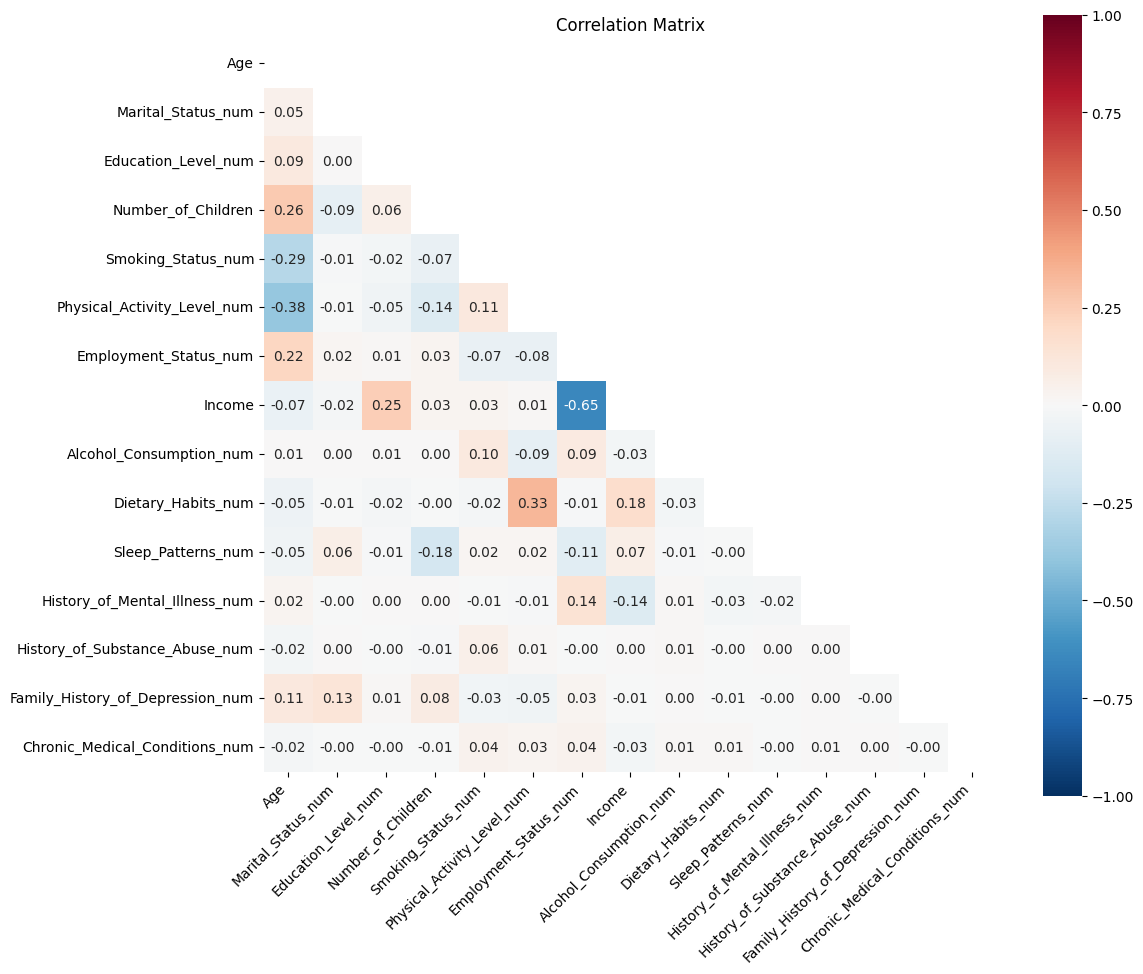

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql.functions import col

# 1. Konversi categorical columns ke numeric
def convert_to_numeric(df, categorical_cols):
    """Convert categorical columns to numeric using StringIndexer"""
    for col_name in categorical_cols:
        indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_num")
        df = indexer.fit(df).transform(df)
    return df

# 2. Hitung correlation matrix
def create_correlation_matrix(df):
    # Convert Spark DataFrame to Pandas
    pdf = df.toPandas()

    # Calculate correlation matrix
    corr_matrix = pdf.corr(method='pearson')

    return corr_matrix

# 3. Plot correlation matrix
def plot_correlation_matrix(corr_matrix):
    plt.figure(figsize=(12, 10))

    # Create heatmap using seaborn
    mask = np.zeros_like(corr_matrix)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr_matrix,
                annot=True,          # Tampilkan nilai
                fmt='.2f',           # Format 2 desimal
                cmap='RdBu_r',       # Color map merah-putih-biru
                square=True,         # Buat kotak persegi
                mask=mask,           # Gunakan mask untuk segitiga atas
                vmin=-1,             # Minimum value
                vmax=1,              # Maximum value
                center=0)            # Center point untuk colormap

    plt.title('Correlation Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Implementasi
# 1. Siapkan data
categorical_cols = [
    "Marital_Status", "Education_Level", "Smoking_Status",
    "Physical_Activity_Level", "Employment_Status",
    "Alcohol_Consumption", "Dietary_Habits", "Sleep_Patterns",
    "History_of_Mental_Illness", "History_of_Substance_Abuse",
    "Family_History_of_Depression", "Chronic_Medical_Conditions"
]

# 2. Convert categorical ke numeric
df_numeric = convert_to_numeric(df, categorical_cols)

# 3. Pilih kolom untuk correlation
columns_for_correlation = [
    'Age', 'Marital_Status_num', 'Education_Level_num',
    'Number_of_Children', 'Smoking_Status_num',
    'Physical_Activity_Level_num', 'Employment_Status_num',
    'Income', 'Alcohol_Consumption_num', 'Dietary_Habits_num',
    'Sleep_Patterns_num', 'History_of_Mental_Illness_num',
    'History_of_Substance_Abuse_num', 'Family_History_of_Depression_num',
    'Chronic_Medical_Conditions_num'
]

# 4. Hitung dan plot correlation matrix
corr_matrix = create_correlation_matrix(df_numeric.select(columns_for_correlation))
plot_correlation_matrix(corr_matrix)

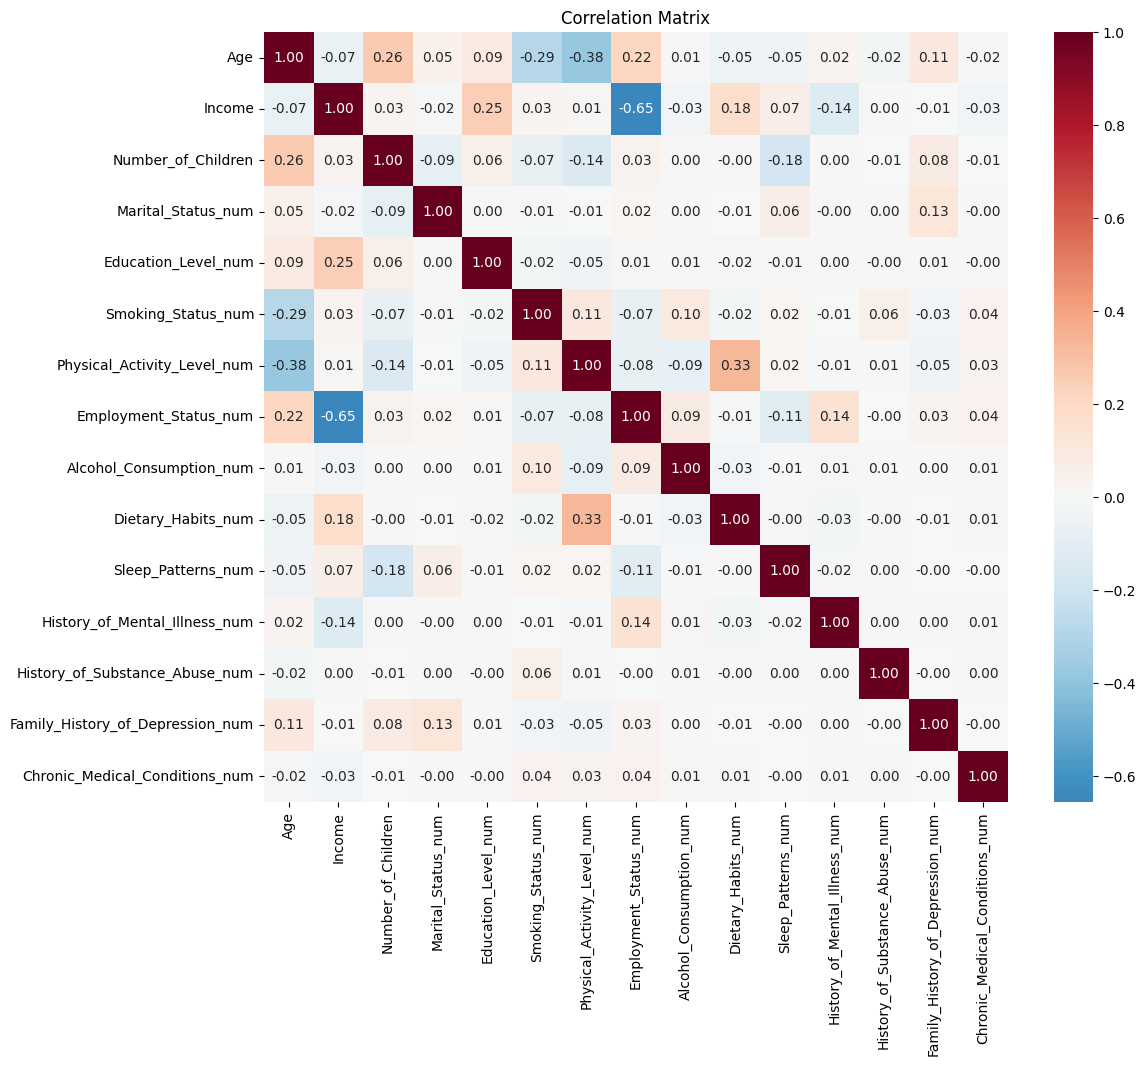

In [6]:
def create_correlation_matrix(df, numeric_cols, categorical_cols):
    # Convert categorical to numeric
    df_numeric = df
    for cat_col in categorical_cols:
        indexer = StringIndexer(inputCol=cat_col, outputCol=f"{cat_col}_num")
        df_numeric = indexer.fit(df_numeric).transform(df_numeric)

    # Select numeric columns
    columns_for_correlation = numeric_cols + [f"{col}_num" for col in categorical_cols]

    # Convert to pandas
    pdf = df_numeric.select(columns_for_correlation).toPandas()

    # Calculate correlation
    correlation_matrix = pdf.corr()

    return correlation_matrix

# Plot correlation matrix
def plot_correlation_matrix(correlation_matrix):
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix,
                annot=True,
                cmap='RdBu_r',
                center=0,
                fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

# Create and plot correlation matrix
corr_matrix = create_correlation_matrix(df, numeric_cols, categorical_cols)
plot_correlation_matrix(corr_matrix)

In [7]:
def create_enhanced_features(df):

    # 1. Socioeconomic Score
    df = df.withColumn(
        "socioeconomic_score",
        when((col("Employment_Status") == "Employed") & (col("Income") > 50000), 3)
        .when((col("Employment_Status") == "Employed") & (col("Income") > 30000), 2)
        .when(col("Employment_Status") == "Employed", 1)
        .otherwise(0)
    )

    # 2. Lifestyle Health Score
    df = df.withColumn(
        "lifestyle_health_score",
        when((col("Physical_Activity_Level") == "Active") &
             (col("Dietary_Habits") == "Healthy"), 3)
        .when((col("Physical_Activity_Level") == "Moderate") |
              (col("Dietary_Habits") == "Moderate"), 2)
        .when((col("Physical_Activity_Level") == "Sedentary") &
              (col("Dietary_Habits") == "Unhealthy"), 0)
        .otherwise(1)
    )

    # 3. Age-Based Risk Score
    df = df.withColumn(
        "age_risk_score",
        when((col("Age") > 50) & (col("Physical_Activity_Level") == "Sedentary"), 3)
        .when((col("Age") > 40) & (col("Employment_Status") == "Unemployed"), 2)
        .when(col("Age") > 60, 2)
        .otherwise(1)
    )

    # 4. Mental Health Risk Score
    df = df.withColumn(
        "mental_health_risk_score",
        when((col("History_of_Mental_Illness") == "Yes") &
             (col("Family_History_of_Depression") == "Yes"), 4)
        .when(col("History_of_Mental_Illness") == "Yes", 3)
        .when(col("Family_History_of_Depression") == "Yes", 2)
        .when(col("Sleep_Patterns") == "Poor", 1)
        .otherwise(0)
    )

    # 5. Social Support Index
    df = df.withColumn(
        "social_support_index",
        when((col("Marital_Status") == "Married") &
             (col("Employment_Status") == "Employed"), 3)
        .when(col("Marital_Status").isin(["Married", "Partnership"]), 2)
        .when(col("Employment_Status") == "Employed", 1)
        .otherwise(0)
    )

    # 6. Substance Risk Score
    df = df.withColumn(
        "substance_risk_score",
        when((col("Smoking_Status") == "Smoker") &
             (col("Alcohol_Consumption") == "High"), 3)
        .when((col("Smoking_Status") == "Smoker") |
              (col("Alcohol_Consumption") == "High"), 2)
        .when((col("Smoking_Status") == "Former-smoker") |
              (col("Alcohol_Consumption") == "Moderate"), 1)
        .otherwise(0)
    )

    # 7. Combined Health Risk Score
    df = df.withColumn(
        "combined_health_risk",
        col("mental_health_risk_score") +
        col("substance_risk_score") +
        col("age_risk_score")
    )

    return df

# Apply feature engineering
df_enhanced = create_enhanced_features(df)

In [11]:
# 1. Pertama, buat enhanced features
df = create_enhanced_features(df)

# 2. Kemudian siapkan feature untuk model
selected_features = [
    # Feature asli
    "Age", "Number_of_Children", "Income",
    "Marital_Status", "Education_Level", "Smoking_Status",
    "Physical_Activity_Level", "Employment_Status",
    "Alcohol_Consumption", "Dietary_Habits", "Sleep_Patterns",
    "Family_History_of_Depression", "Chronic_Medical_Conditions",

    # Feature turunan
    "socioeconomic_score",
    "lifestyle_health_score",
    "age_risk_score",
    "social_support_index",
    "substance_risk_score",
    "combined_health_risk"
]

# 3. Pisahkan numeric dan categorical columns
numeric_cols = [
    "Age", "Number_of_Children", "Income",
    "socioeconomic_score", "lifestyle_health_score",
    "age_risk_score", "social_support_index",
    "substance_risk_score", "combined_health_risk"
]

categorical_cols = [
    "Marital_Status", "Education_Level", "Smoking_Status",
    "Physical_Activity_Level", "Employment_Status",
    "Alcohol_Consumption", "Dietary_Habits", "Sleep_Patterns",
    "Family_History_of_Depression", "Chronic_Medical_Conditions"
]

# 4. Buat label
df = df.withColumn("depression_risk",
    when(col("History_of_Mental_Illness") == "Yes", 1.0)
    .otherwise(0.0)
)

In [12]:
# Pisahkan feature dan label
label_column = "History_of_Mental_Illness"

# Konversi label menjadi binary (0/1)
df = df.withColumn("depression_risk",
    when(col(label_column) == "Yes", 1.0)
    .otherwise(0.0)
)

# Daftar feature yang akan digunakan (exclude History_of_Mental_Illness)
selected_features = [
    "Age", "Marital_Status", "Education_Level",
    "Number_of_Children", "Smoking_Status",
    "Physical_Activity_Level", "Employment_Status",
    "Income", "Alcohol_Consumption", "Dietary_Habits",
    "Sleep_Patterns", "Family_History_of_Depression",
    "Chronic_Medical_Conditions",
    # Derived features
    "socioeconomic_score", "lifestyle_health_score",
    "age_risk_score", "social_support_index",
    "substance_risk_score", "combined_health_risk"
]

In [13]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Identifikasi kolom kategorikal dan numerik
categorical_cols = [
    "Marital_Status", "Education_Level", "Smoking_Status",
    "Physical_Activity_Level", "Employment_Status",
    "Alcohol_Consumption", "Dietary_Habits", "Sleep_Patterns",
    "Family_History_of_Depression", "Chronic_Medical_Conditions"
]
numeric_cols = [
    "Age", "Number_of_Children", "Income",
    "socioeconomic_score", "lifestyle_health_score",
    "age_risk_score", "social_support_index",
    "substance_risk_score", "combined_health_risk"
]

# Buat stages untuk pipeline
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed")
           for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_encoded")
           for col in categorical_cols]

# Gabungkan semua feature
encoded_cols = [f"{col}_encoded" for col in categorical_cols]
assembler = VectorAssembler(
    inputCols=numeric_cols + encoded_cols,
    outputCol="features"
)

# Buat pipeline
pipeline_stages = indexers + encoders + [assembler]

In [14]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Split data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Buat pipeline final dengan classifier
rf = RandomForestClassifier(
    labelCol="depression_risk",
    featuresCol="features",
    numTrees=100
)
pipeline = Pipeline(stages=pipeline_stages + [rf])

# Train model
model = pipeline.fit(train_data)

# Prediksi
predictions = model.transform(test_data)

In [15]:
# Evaluasi menggunakan beberapa metrik
def evaluate_model(predictions):
    # Binary Classification Evaluator
    evaluator = BinaryClassificationEvaluator(
        labelCol="depression_risk",
        rawPredictionCol="rawPrediction"
    )

    # Area under ROC
    auc_roc = evaluator.evaluate(predictions)

    # Confusion Matrix
    confusion_matrix = predictions.select("depression_risk", "prediction")\
        .groupBy("depression_risk", "prediction").count().show()

    # Accuracy
    accuracy = predictions.filter(col("depression_risk") == col("prediction"))\
        .count() / float(predictions.count())

    print(f"Area under ROC: {auc_roc}")
    print(f"Accuracy: {accuracy}")
    print("\nConfusion Matrix:")
    confusion_matrix

# Evaluasi model
evaluate_model(predictions)

+---------------+----------+-----+
|depression_risk|prediction|count|
+---------------+----------+-----+
|            1.0|       1.0|18043|
|            0.0|       1.0| 1673|
|            1.0|       0.0| 6946|
|            0.0|       0.0|56299|
+---------------+----------+-----+

Area under ROC: 0.974559703254183
Accuracy: 0.8961078096937115

Confusion Matrix:


In [41]:
# File: test_functions.py
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

def create_test_data_single_row(spark, test_data):
    """
    Fungsi untuk membuat DataFrame test dari satu baris data
    """
    # Schema untuk data awal
    schema = StructType([
        StructField("Age", IntegerType(), True),
        StructField("Marital_Status", StringType(), True),
        StructField("Education_Level", StringType(), True),
        StructField("Number_of_Children", IntegerType(), True),
        StructField("Smoking_Status", StringType(), True),
        StructField("Physical_Activity_Level", StringType(), True),
        StructField("Employment_Status", StringType(), True),
        StructField("Income", DoubleType(), True),
        StructField("Alcohol_Consumption", StringType(), True),
        StructField("Dietary_Habits", StringType(), True),
        StructField("Sleep_Patterns", StringType(), True),
        StructField("Family_History_of_Depression", StringType(), True),
        StructField("Chronic_Medical_Conditions", StringType(), True),
        StructField("History_of_Mental_Illness", StringType(), True)
    ])

    # Create DataFrame dengan data awal
    test_df = spark.createDataFrame([test_data], schema=schema)

    # Tambahkan derived features menggunakan fungsi yang sudah ada
    test_df = create_enhanced_features(test_df)

    return test_df

In [45]:
# File: test_data.py

# Data untuk pasien tidak berisiko
HEALTHY_PATIENT = (
    30, "Single", "Bachelor's Degree", 0, "Non-smoker", "Active",
    "Employed", 60000.0, "Low", "Healthy", "Good", "No", "No", "No"
)

# Data untuk pasien berisiko
AT_RISK_PATIENT = (
    25, "Single", "Bachelor's Degree", 0, "Former", "Sedentary",
    "Unemployed", 0.0, "High", "Unhealthy", "Poor", "Yes", "Yes", "Yes"
)

In [46]:


def test_prediction():
    # Test data tidak berisiko
    test_data = create_test_data_single_row(spark, HEALTHY_PATIENT)
    result = predict_depression_risk(model, test_data)
    print("Hasil prediksi pasien sehat:")
    result.show()

    # Test data berisiko
    test_data_risk = create_test_data_single_row(spark, AT_RISK_PATIENT)
    result_risk = predict_depression_risk(model, test_data_risk)
    print("Hasil prediksi pasien berisiko:")
    result_risk.show()

# Jalankan test
test_prediction()

Hasil prediksi pasien sehat:
+---+--------------+-----------------+-----------------+--------------+--------------+
|Age|Marital_Status|  Education_Level|Employment_Status|Sleep_Patterns|hasil_prediksi|
+---+--------------+-----------------+-----------------+--------------+--------------+
| 30|        Single|Bachelor's Degree|         Employed|          Good|Tidak Berisiko|
+---+--------------+-----------------+-----------------+--------------+--------------+

Hasil prediksi pasien berisiko:
+---+--------------+-----------------+-----------------+--------------+--------------+
|Age|Marital_Status|  Education_Level|Employment_Status|Sleep_Patterns|hasil_prediksi|
+---+--------------+-----------------+-----------------+--------------+--------------+
| 25|        Single|Bachelor's Degree|       Unemployed|          Poor|      Berisiko|
+---+--------------+-----------------+-----------------+--------------+--------------+



In [63]:
# Cell 1 - Import libraries
import matplotlib.pyplot as plt
import seaborn as sns

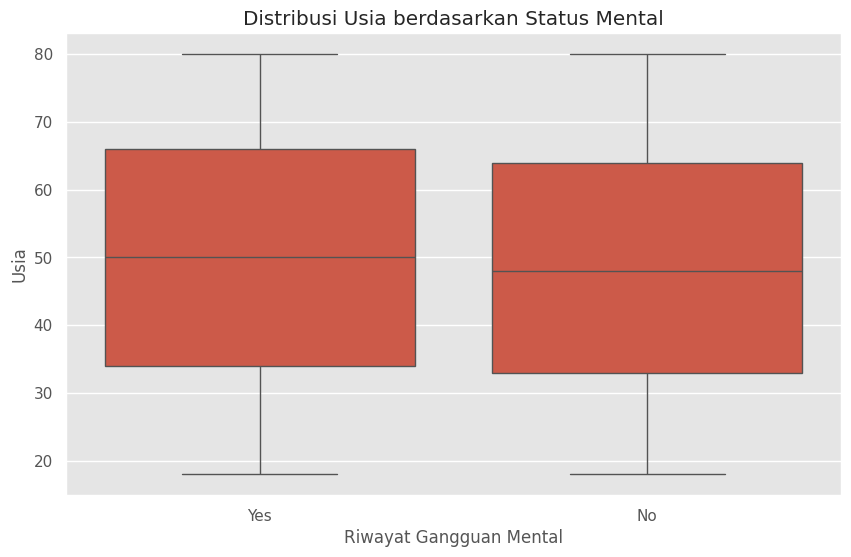

In [64]:
# Cell 2 - Distribusi Usia
plt.figure(figsize=(10, 6))
sns.boxplot(x='History_of_Mental_Illness', y='Age', data=df.toPandas())
plt.title('Distribusi Usia berdasarkan Status Mental')
plt.xlabel('Riwayat Gangguan Mental')
plt.ylabel('Usia')
plt.show()

<Figure size 1200x600 with 0 Axes>

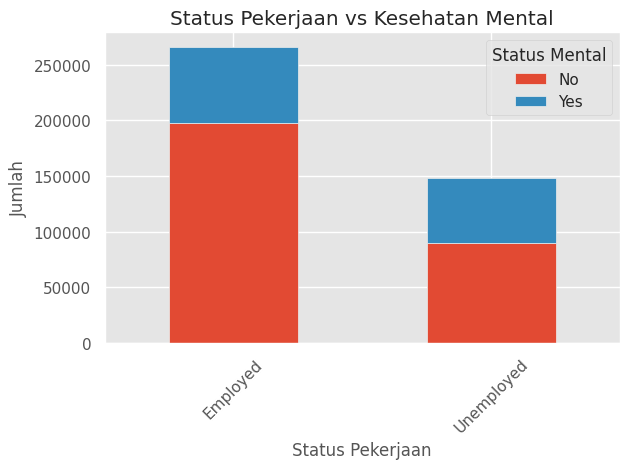

In [65]:
# Cell 3 - Status Pekerjaan
plt.figure(figsize=(12, 6))
employment_counts = df.groupBy('Employment_Status', 'History_of_Mental_Illness').count().toPandas()
employment_pivot = employment_counts.pivot(
    index='Employment_Status',
    columns='History_of_Mental_Illness',
    values='count'
).fillna(0)

employment_pivot.plot(kind='bar', stacked=True)
plt.title('Status Pekerjaan vs Kesehatan Mental')
plt.xlabel('Status Pekerjaan')
plt.ylabel('Jumlah')
plt.legend(title='Status Mental')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

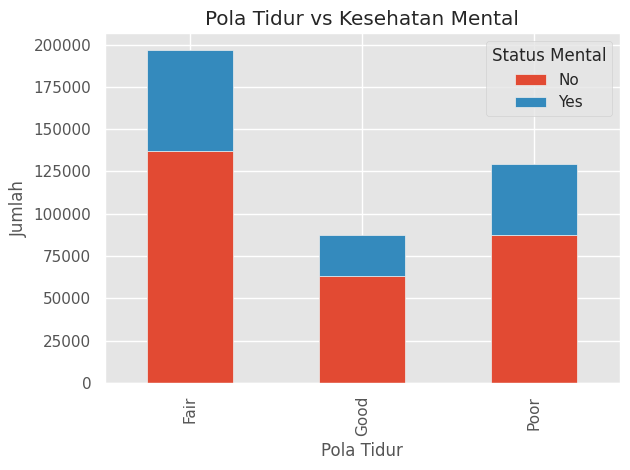

In [66]:
# Cell 4 - Pola Tidur
plt.figure(figsize=(10, 6))
sleep_counts = df.groupBy('Sleep_Patterns', 'History_of_Mental_Illness').count().toPandas()
sleep_pivot = sleep_counts.pivot(
    index='Sleep_Patterns',
    columns='History_of_Mental_Illness',
    values='count'
).fillna(0)

sleep_pivot.plot(kind='bar', stacked=True)
plt.title('Pola Tidur vs Kesehatan Mental')
plt.xlabel('Pola Tidur')
plt.ylabel('Jumlah')
plt.legend(title='Status Mental')
plt.tight_layout()
plt.show()

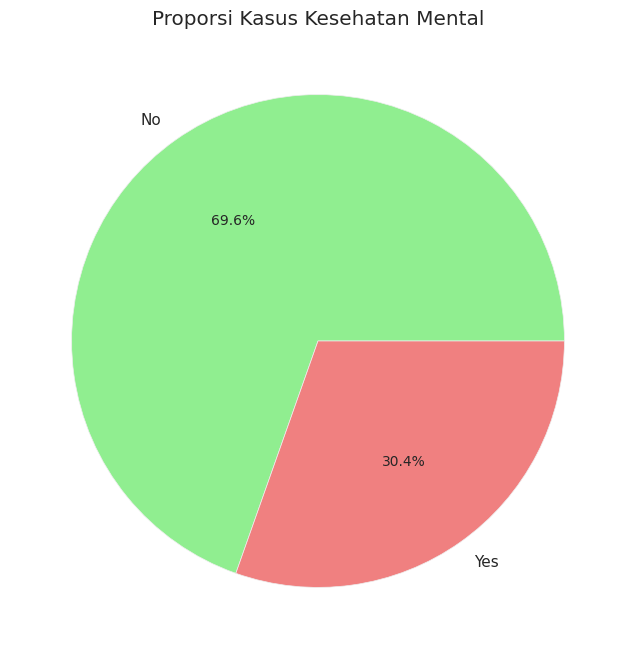

In [67]:
# Cell 5 - Proporsi Kasus
plt.figure(figsize=(8, 8))
mental_counts = df.groupBy('History_of_Mental_Illness').count().toPandas()
plt.pie(mental_counts['count'],
        labels=mental_counts['History_of_Mental_Illness'],
        autopct='%1.1f%%',
        colors=['lightgreen', 'lightcoral'])
plt.title('Proporsi Kasus Kesehatan Mental')
plt.show()

<Figure size 1000x600 with 0 Axes>

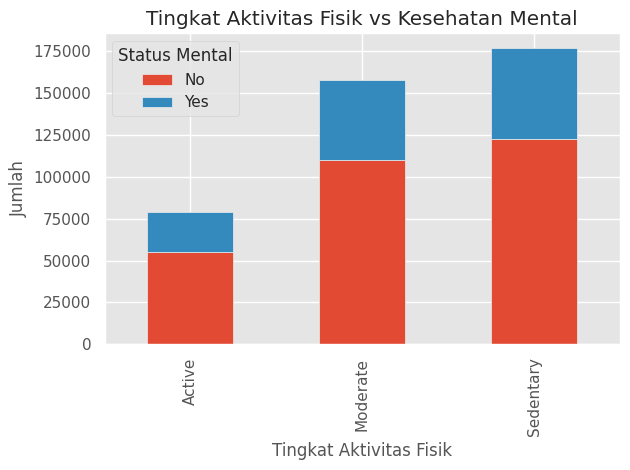

In [68]:
# Cell 6 - Aktivitas Fisik
plt.figure(figsize=(10, 6))
activity_counts = df.groupBy('Physical_Activity_Level', 'History_of_Mental_Illness').count().toPandas()
activity_pivot = activity_counts.pivot(
    index='Physical_Activity_Level',
    columns='History_of_Mental_Illness',
    values='count'
).fillna(0)

activity_pivot.plot(kind='bar', stacked=True)
plt.title('Tingkat Aktivitas Fisik vs Kesehatan Mental')
plt.xlabel('Tingkat Aktivitas Fisik')
plt.ylabel('Jumlah')
plt.legend(title='Status Mental')
plt.tight_layout()
plt.show()

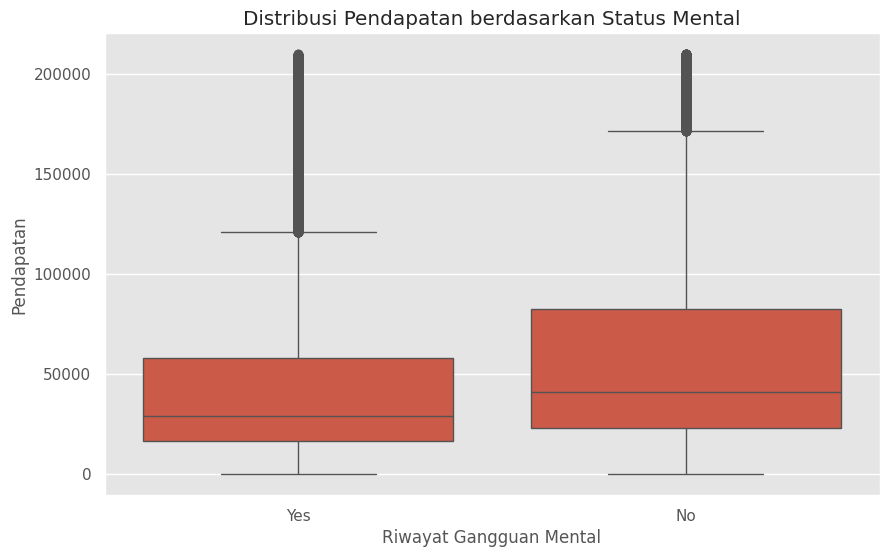

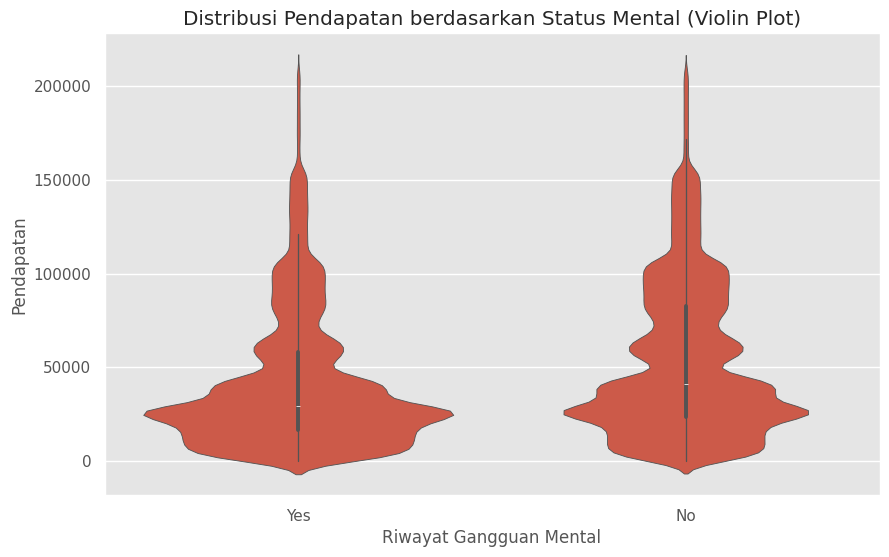

In [70]:
# Distribusi Income terhadap Mental Illness
plt.figure(figsize=(10, 6))
sns.boxplot(x='History_of_Mental_Illness', y='Income', data=df.toPandas())
plt.title('Distribusi Pendapatan berdasarkan Status Mental')
plt.xlabel('Riwayat Gangguan Mental')
plt.ylabel('Pendapatan')
plt.show()

# Alternatif view dengan violin plot untuk melihat distribusi lebih detail
plt.figure(figsize=(10, 6))
sns.violinplot(x='History_of_Mental_Illness', y='Income', data=df.toPandas())
plt.title('Distribusi Pendapatan berdasarkan Status Mental (Violin Plot)')
plt.xlabel('Riwayat Gangguan Mental')
plt.ylabel('Pendapatan')
plt.show()

<Figure size 1000x600 with 0 Axes>

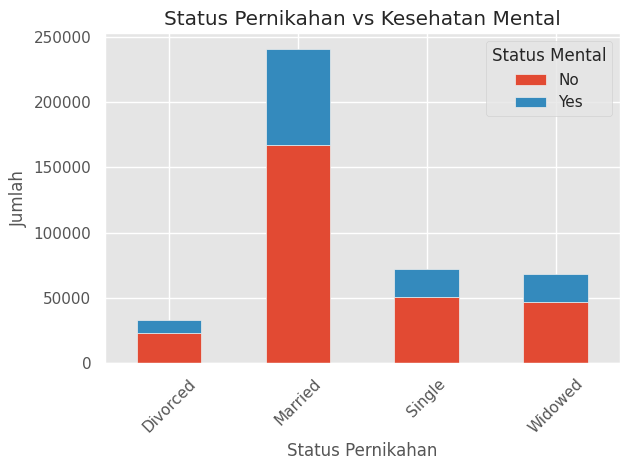

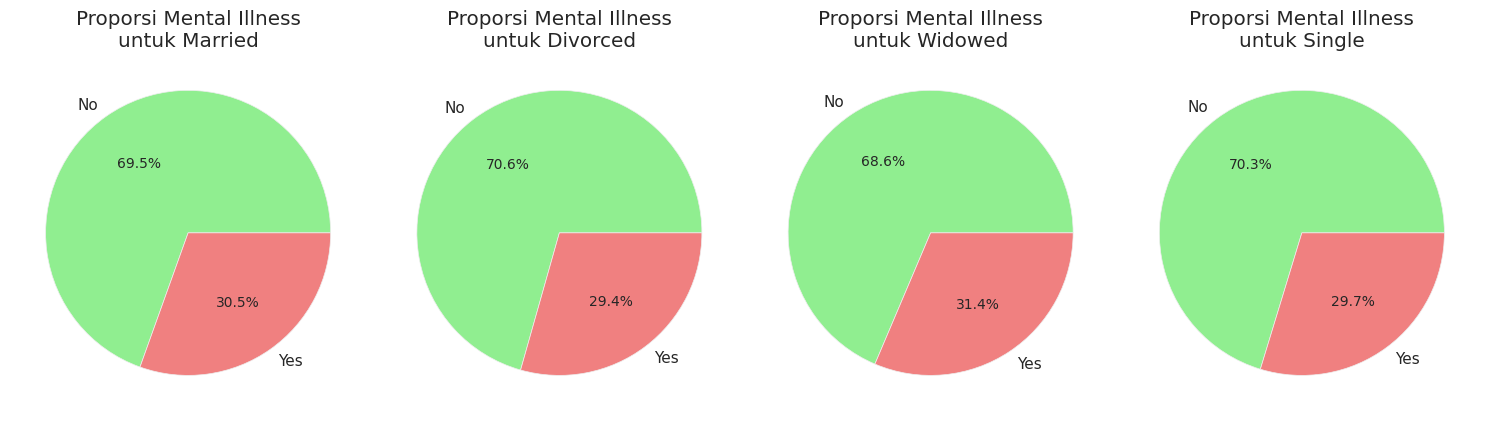

In [71]:
# Distribusi Status Pernikahan terhadap Mental Illness
plt.figure(figsize=(10, 6))
marital_counts = df.groupBy('Marital_Status', 'History_of_Mental_Illness').count().toPandas()
marital_pivot = marital_counts.pivot(
    index='Marital_Status',
    columns='History_of_Mental_Illness',
    values='count'
).fillna(0)

marital_pivot.plot(kind='bar', stacked=True)
plt.title('Status Pernikahan vs Kesehatan Mental')
plt.xlabel('Status Pernikahan')
plt.ylabel('Jumlah')
plt.legend(title='Status Mental')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Persentase dalam pie chart untuk setiap status pernikahan
plt.figure(figsize=(15, 5))
marital_statuses = df.select('Marital_Status').distinct().collect()

for i, status in enumerate(marital_statuses, 1):
    status = status['Marital_Status']
    plt.subplot(1, len(marital_statuses), i)

    mental_counts = df.filter(df.Marital_Status == status)\
                     .groupBy('History_of_Mental_Illness').count().toPandas()

    plt.pie(mental_counts['count'],
            labels=mental_counts['History_of_Mental_Illness'],
            autopct='%1.1f%%',
            colors=['lightgreen', 'lightcoral'])
    plt.title(f'Proporsi Mental Illness\nuntuk {status}')

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

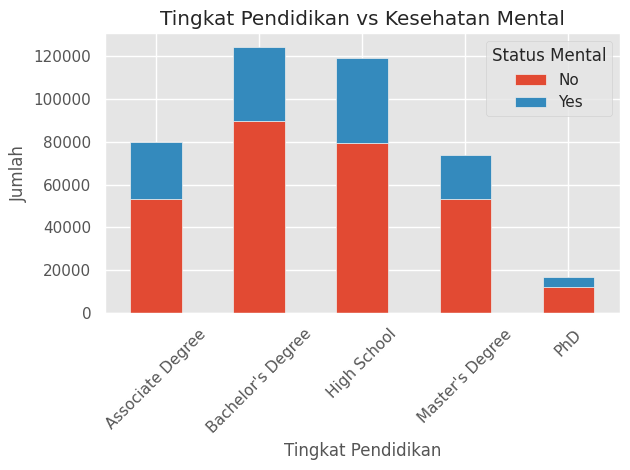

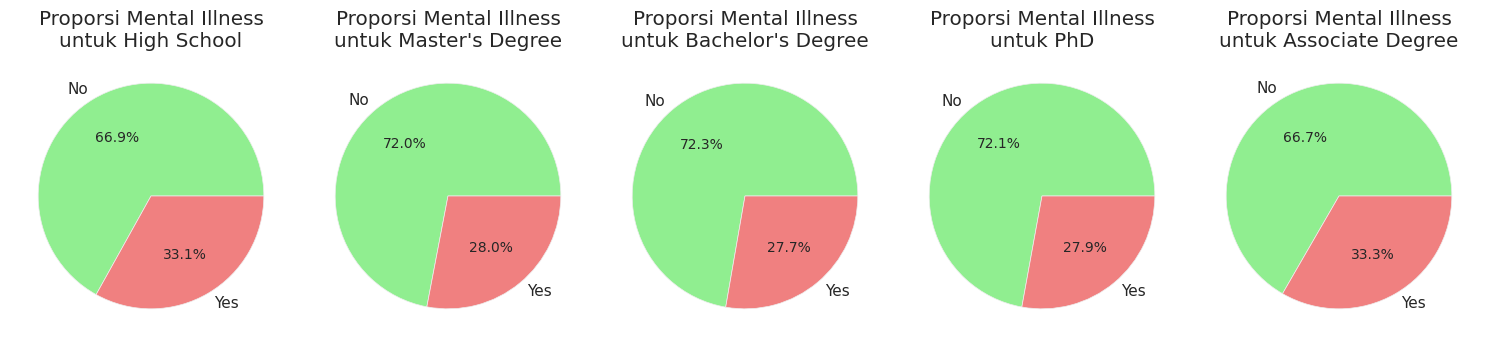

In [72]:
# Distribusi Tingkat Pendidikan terhadap Mental Illness
plt.figure(figsize=(12, 6))
education_counts = df.groupBy('Education_Level', 'History_of_Mental_Illness').count().toPandas()
education_pivot = education_counts.pivot(
    index='Education_Level',
    columns='History_of_Mental_Illness',
    values='count'
).fillna(0)

education_pivot.plot(kind='bar', stacked=True)
plt.title('Tingkat Pendidikan vs Kesehatan Mental')
plt.xlabel('Tingkat Pendidikan')
plt.ylabel('Jumlah')
plt.legend(title='Status Mental')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Persentase dalam pie chart untuk setiap tingkat pendidikan
plt.figure(figsize=(15, 5))
education_levels = df.select('Education_Level').distinct().collect()

for i, level in enumerate(education_levels, 1):
    level = level['Education_Level']
    plt.subplot(1, len(education_levels), i)

    mental_counts = df.filter(df.Education_Level == level)\
                     .groupBy('History_of_Mental_Illness').count().toPandas()

    plt.pie(mental_counts['count'],
            labels=mental_counts['History_of_Mental_Illness'],
            autopct='%1.1f%%',
            colors=['lightgreen', 'lightcoral'])
    plt.title(f'Proporsi Mental Illness\nuntuk {level}')

plt.tight_layout()
plt.show()